**Notebook du TP 1**
21 decembre 2018

L'analyse des résultats est diponible dans le fichier pdf (Rapport_RENGOT_juliette)


In [2]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, UpSampling1D, Dropout
from keras.utils.np_utils import to_categorical
from sklearn import *
import random
import math

Using TensorFlow backend.


In [0]:
def generate_a_drawing(figsize, U, V, noise=0.0):
    fig = plt.figure(figsize=(figsize,figsize))
    ax = plt.subplot(111)
    plt.axis('Off')
    ax.set_xlim(0,figsize)
    ax.set_ylim(0,figsize)
    ax.fill(U, V, "k")
    fig.canvas.draw()
    imdata = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)[::3].astype(np.float32)
    imdata = imdata + noise * np.random.random(imdata.size)
    #plt.show()
    plt.close(fig)
    return imdata

def generate_a_rectangle(noise=0.0, free_location=False, pair=False):
    figsize = 1.0    
    U = np.zeros(4)
    V = np.zeros(4)
    if free_location:
        corners = np.random.random(4)
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
    else:
        side = (0.3 + 0.7 * np.random.random()) * figsize
        top = figsize/2 + side/2
        bottom = figsize/2 - side/2
        left = bottom
        right = top
    U[0] = U[1] = top
    U[2] = U[3] = bottom
    V[0] = V[3] = left
    V[1] = V[2] = right
     
    if (pair):
        A = generate_a_drawing(figsize, U, V, noise)
        B = generate_a_drawing(figsize, U, V, 0)
        return(A,B)
    return generate_a_drawing(figsize, U, V, noise)

def generate_a_disk(noise=0.0, free_location=False, pair=False):
    figsize = 1.0
    if free_location:
        center = np.random.random(2)
    else:
        center = (figsize/2, figsize/2)
    radius = (0.3 + 0.7 * np.random.random()) * figsize/2
    N = 50
    U = np.zeros(N)
    V = np.zeros(N)
    i = 0
    for t in np.linspace(0, 2*np.pi, N):
        U[i] = center[0] + np.cos(t) * radius
        V[i] = center[1] + np.sin(t) * radius
        i = i + 1
    
    if(pair):
        A = generate_a_drawing(figsize, U, V, noise)
        B = generate_a_drawing(figsize, U, V, 0)
        return(A,B)
    
    return generate_a_drawing(figsize, U, V, noise)

def generate_a_triangle(noise=0.0, free_location=False, pair=False):
    figsize = 1.0
    if free_location:
        U = np.random.random(3)
        V = np.random.random(3)
    else:
        size = (0.3 + 0.7 * np.random.random())*figsize/2
        middle = figsize/2
        U = (middle, middle+size, middle-size)
        V = (middle+size, middle-size, middle-size)
    imdata = generate_a_drawing(figsize, U, V, noise)
    
    if (pair):
        A = [imdata, [U[0], V[0], U[1], V[1], U[2], V[2]]]
        imdata2 = generate_a_drawing(figsize, U, V, 0)
        B = [imdata2, [U[0], V[0], U[1], V[1], U[2], V[2]]]
        return(A,B)
    
    return [imdata, [U[0], V[0], U[1], V[1], U[2], V[2]]]

In [0]:
def generate_dataset_classification(nb_samples, noise=0.0, free_location=False):
    # Getting im_size:
    im_size = generate_a_rectangle().shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros(nb_samples)
    print('Creating data:')
    for i in range(nb_samples):
        if i % 10 == 0:
            print(i)
        category = np.random.randint(3)
        if category == 0:
            X[i] = generate_a_rectangle(noise, free_location)
        elif category == 1: 
            X[i] = generate_a_disk(noise, free_location)
        else:
            [X[i], V] = generate_a_triangle(noise, free_location)
        Y[i] = category
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

def generate_dataset_denoising(nb_samples, noise=10.0, size_reduction=1, free_location=False):
    # Getting im_size:
    im_size = generate_a_rectangle().shape[0]
    im_edge = int(math.sqrt(im_size))
    print(im_edge)
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros([nb_samples,im_size])
    print('Creating data:')
    for i in range(nb_samples):
        if i % 10 == 0:
            print(i)
        category = np.random.randint(3)
        if category == 0:
            X[i], Y[i] = generate_a_rectangle(noise, free_location, True)
        elif category == 1: 
            X[i], Y[i] = generate_a_disk(noise, free_location, True)
        else:
            [X[i], V], [Y[i], V] = generate_a_triangle(noise, free_location, True)
    X = (X + noise) / (255 + 2 * noise)
    Y = Y / 255
    
    #reshape
    X = X.reshape((nb_samples, im_edge, im_edge))
    X = X[:, 0:im_edge:size_reduction, 0:im_edge:size_reduction]
    X = X.reshape((nb_samples,-1))
    Y = Y.reshape((nb_samples, im_edge, im_edge))
    Y = Y[:, 0:im_edge:size_reduction, 0:im_edge:size_reduction]
    Y = Y.reshape((nb_samples,-1))
    return [X, Y]


def generate_test_set_classification():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_classification(300, 20, True)
    Y_test = to_categorical(Y_test, 3) 
    return [X_test, Y_test]

def generate_dataset_regression(nb_samples, noise=0.0):
    # Getting im_size:
    im_size = generate_a_triangle()[0].shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros([nb_samples, 6])
    print('Creating data:')
    for i in range(nb_samples):
        if i % 10 == 0:
            print(i)
        [X[i], Y[i]] = generate_a_triangle(noise, free_location=True)
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

def visualize_prediction(x, y):
    fig, ax = plt.subplots(figsize=(5, 5))
    size = int(math.sqrt(x.shape[0]))
    I = x.reshape((size, size))
    ax.imshow(I, extent=[-0.15,1.15,-0.15,1.15],cmap='gray')
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])

    xy = y.reshape(3,2)
    tri = patches.Polygon(xy, closed=True, fill = False, edgecolor = 'r', linewidth = 5, alpha = 0.5)
    ax.add_patch(tri)

    plt.show()

def generate_test_set_regression():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_regression(300, 20)
    return [X_test, Y_test]

**PART 2 : SIMPLE CLASSIFICATION**

Q1) We build a model with the Keras fonction Sequential. Then we add a Dense layer using a softmax activation function. The input dimension is 10000 (because of the image size) and the output dimension is 3 (because we want to classify the images into three classes : 'rectangle', 'disk' and 'triangle'). We train the model on the training data. Our model has 30003 parameters.

First we use a stochastic gradient descent optimiser ('sgd'). We aim at decreasing the mean_squared_error loss function. At the end of the training, we ave loss: 0.0075 - acc: 0.9933 - categorical_accuracy: 0.9933. It is good results. When we test our model on testing data, the output is a (1x3) vector where Yi=0 means that the data doesn't belong to the class i and Yi=1 means that the data belongs to the class i. We see that we are able to put the rectangle data in the class 0, the disk data in the class 1 and the triangle data in the class 2, even if there is some noise. The classification is correct. The network has generalised what he has learned from the training data to correctly classify new data.

Next we use an Adam optimiser ('adam') with batch_size=32. We aim at decreasing the categorical_crossentropy loss function. At the end of the training, we have loss: 0.0018 - acc: 1.0000 - categorical_accuracy: 1.0000. It is even better results. When we test our model on testing data,we obtain the same correct classification.

In [9]:
#Simple classification
[X_train, Y_train] = generate_dataset_classification(500, 20)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  del sys.path[0]


Epoch 1/100
500/500 [==============================] - 0s 507us/step - loss: 1.7696 - acc: 0.4460 - categorical_accuracy: 0.4460
Epoch 2/100
500/500 [==============================] - 0s 140us/step - loss: 0.6752 - acc: 0.6660 - categorical_accuracy: 0.6660
Epoch 3/100
500/500 [==============================] - 0s 139us/step - loss: 0.3925 - acc: 0.9260 - categorical_accuracy: 0.9260
Epoch 4/100
500/500 [==============================] - 0s 131us/step - loss: 0.3360 - acc: 0.8540 - categorical_accuracy: 0.8540
Epoch 5/100
500/500 [==============================] - 0s 140us/step - loss: 0.2614 - acc: 0.9580 - categorical_accuracy: 0.9580
Epoch 6/100
500/500 [==============================] - 0s 129us/step - loss: 0.2073 - acc: 0.9860 - categorical_accuracy: 0.9860
Epoch 7/100
500/500 [==============================] - 0s 149us/step - loss: 0.1817 - acc: 0.9720 - categorical_accuracy: 0.9720
Epoch 8/100
500/500 [==============================] - 0s 139us/step - loss: 0.1608 - acc: 0.9820

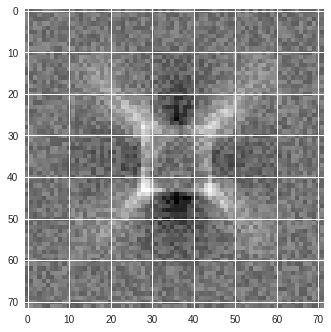

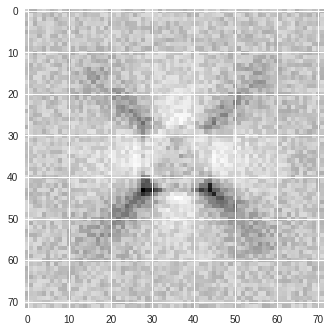

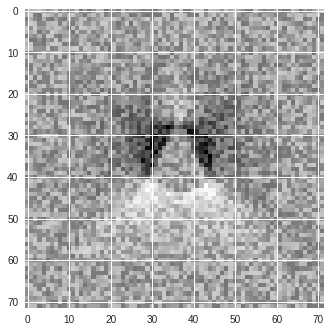

In [11]:
# Build model
model = Sequential()
model.add(Dense(3, input_dim=X_train.shape[1], activation="softmax"))

#opti = 'sgd' #Stochastic gradient descent optimizer.
#loss='mean_squared_error'

opti = 'adam' #adam optimizer
loss='categorical_crossentropy'

model.compile(loss=loss, optimizer=opti, metrics=['accuracy', 'categorical_accuracy'])

# Train
model.fit(X_train, to_categorical(Y_train, 3), batch_size=32, nb_epoch=100)
model.summary()

#Test
X_test = generate_a_rectangle(noise=20)
X_test = X_test.reshape(1, X_test.shape[0])
Y_test = model.predict(X_test)
print("Result rectangle",np.argmax(Y_test))
X_test = generate_a_disk()
X_test = X_test.reshape(1, X_test.shape[0])
Y_test = model.predict(X_test)
print("Result disk",np.argmax(Y_test))
[X_test, v] = generate_a_triangle(20, False)
X_test = X_test.reshape(1, X_test.shape[0])
Y_test = model.predict(X_test)
print("Result triangle", np.argmax(Y_test))

#Visualization
size = int(math.sqrt(X_train.shape[1]))
plt.imshow((model.get_weights()[0][:,0]).reshape(size, size))
plt.show()
plt.imshow((model.get_weights()[0][:,1]).reshape(size, size))
plt.show()
plt.imshow((model.get_weights()[0][:,2]).reshape(size, size))
plt.show()

**PART 3 : VISUALIZATION OF THE SOLUTION**

Q2) The weights of the first column enable the network to find the rectangle data, the second column, the disk data and the last one, the triangle data. Their distribution in the above images evokes these geometrical forms.

**PART 4 : A MORE DIFFICULT CLASSIFICATION PROBLEM**

Q3) Now, the shapes are allowed to move within the images and change dimensions. With the previous model, the results are not satisfying. The model evaluation gives a loss value of 5.0755513890584307, an accuracy of 0.56666666686534883, and a categorical accuracy of 0.56666666686534883. To improve these results, we need a more sophisticated network.

This time, the two first layer of our model are an 1D convolution of 16 filters with kernel size (5x5). Then, we add a max-pooling layer. We flatten the output and we apply a Dense layer with softmax activation. We use Adam optimiser and categorical_crossentropy loss function. The model has 240003 parameters. The model evaluation gives a loss value of 0.0025, an accuracy of 1, and a categorical accuracy of 1. We are not able to do the classification correctly.

In [12]:
#A more difficult classification
n_samples = 300
[X_train, Y_train] = generate_dataset_classification(n_samples, 20, True)
model.fit(X_train, to_categorical(Y_train, 3), batch_size=32, nb_epoch=100)
[X_test, Y_test] = generate_test_set_classification()
print("model evaluating")
model.evaluate(X_test, Y_test)

#covolutional model
model2 = Sequential()
model2.add(Conv1D(16, 5, input_shape=(X_train.shape[1], 1)))
model2.add(Conv1D(16, 5))
model2.add(MaxPooling1D())
model2.add(Flatten())
model2.add(Dense(3, activation="softmax"))
model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', 'categorical_accuracy'])

model2.summary()

# Train
print("model2 fitting")
model2.fit(X_train.reshape((n_samples, -1, 1)), to_categorical(Y_train, 3), batch_size=32, nb_epoch=100)
#Test
print("model2 evaluate")
model2.evaluate(X_test.reshape((X_test.shape[0], -1, 1)), Y_test)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
Epoch 1/100
300/300 [==============================] - 0s 140us/step - loss: 5.0815 - acc: 0.2900 - categorical_accuracy: 0.2900
Epoch 2/100
300/300 [==============================] - 0s 112us/step - loss: 3.7281 - acc: 0.3667 - categorical_accuracy: 0.3667
Epoch 3/100
300/300 [==============================] - 0s 112us/step - loss: 4.2233 - acc: 0.3933 - categorical_accuracy: 0.3933
Epoch 4/100
300/300 [==============================] - 0s 115us/step - loss: 4.2301 - acc: 0.4033 - categorical_accuracy: 0.4033
Epoch 5/100
 32/300 [==>...........................] - ETA: 0s - loss: 2.7604 - acc: 0.4062 - categorical_accuracy: 0.4062

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  This is separate from the ipykernel package so we can avoid doing imports until


300/300 [==============================] - 0s 124us/step - loss: 4.7978 - acc: 0.3367 - categorical_accuracy: 0.3367
Epoch 6/100
300/300 [==============================] - 0s 124us/step - loss: 5.1508 - acc: 0.4000 - categorical_accuracy: 0.4000
Epoch 7/100
300/300 [==============================] - 0s 134us/step - loss: 3.7597 - acc: 0.4500 - categorical_accuracy: 0.4500
Epoch 8/100
300/300 [==============================] - 0s 128us/step - loss: 2.3417 - acc: 0.5067 - categorical_accuracy: 0.5067
Epoch 9/100
300/300 [==============================] - 0s 129us/step - loss: 1.6565 - acc: 0.5567 - categorical_accuracy: 0.5567
Epoch 10/100
300/300 [==============================] - 0s 123us/step - loss: 1.7965 - acc: 0.5133 - categorical_accuracy: 0.5133
Epoch 11/100
300/300 [==============================] - 0s 112us/step - loss: 1.9689 - acc: 0.5267 - categorical_accuracy: 0.5267
Epoch 12/100
300/300 [==============================] - 0s 122us/step - loss: 1.7929 - acc: 0.5000 - catego

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Epoch 1/100
300/300 [==============================] - 3s 8ms/step - loss: 5.4049 - acc: 0.3433 - categorical_accuracy: 0.3433
Epoch 2/100
300/300 [==============================] - 2s 7ms/step - loss: 4.3093 - acc: 0.3667 - categorical_accuracy: 0.3667
Epoch 3/100
300/300 [==============================] - 2s 7ms/step - loss: 1.6658 - acc: 0.3933 - categorical_accuracy: 0.3933
Epoch 4/100
300/300 [==============================] - 2s 7ms/step - loss: 1.0926 - acc: 0.4667 - categorical_accuracy: 0.4667
Epoch 5/100
300/300 [==============================] - 2s 7ms/step - loss: 0.9867 - acc: 0.5067 - categorical_accuracy: 0.5067
Epoch 6/100
300/300 [==============================] - 2s 7ms/step - loss: 0.8417 - acc: 0.6000 - categorical_accuracy: 0.6000
Epoch 7/100
300/300 [==============================] - 2s 7ms/step - loss: 0.7771 - acc: 0.7133 - categorical_accuracy: 0.7133
Epoch 8/100
300/300 [==============================] - 2s 7ms/step - loss: 0.7332 - acc: 0.7700 - categorical_a

[1.8522545607884724, 0.5299999992052714, 0.5299999992052714]

**PART 5 : A REGRESSION PROBLEM**

Q4) We use a model with more layers. The first layer of our model is an 1D convolution of 16 filters with kernel size (5x5) with relu activation. Then we randomly set 10% of the obtained units to 0 in order to prevent overfitting. It is a dropout layer. Then, we add a 1D convolution, a max-pooling layer, a new dropout layer, another 1D convolution and again a max-pooling layer.  We flatten the output and we apply two times a Dense layer with softmax activation. We use Adam optimiser and mean squared error as a  loss function. The model has 641782 parameters.

We normalise both Y_train and Y_test by apply a translation so that the triangle is not deformed but placed in the bottom left hand corner. Our train set is made of 3000 samples. The fitting takes 100 epochs. At the end on the training, we reach a loss of 0.0243 and an accuracy 0.8750 on the training set. We evaluate the model on the testing set and we get a loss of 0.026789866785208383 and an accuracy of  0.8799999992052714.

We are able to predict, with more or less accuracy the shape of the triangles but not their position in the image. To do that, we have to store the translation apply during the normalisation and apply on the result the opposite one.

The issue of that approach is that we use information on Y_test that should not be available. So, we add the translation parameters in two additional dimantions of Y_train and Y_test and we train our model to learn them too. We evaluate the model on the testing set and we get a loss of 0.05003923654556274 and an accuracy of  0.7233333325386048.

The visualisation is not satisfying. We may be closer to the real triangle but the shape is not really well recognised.

In [7]:
#Regression problem
noise = 20
np.random.seed(42)
[X_train, Y_train] = generate_dataset_regression(3000, noise)
[X_test, Y_test] = generate_test_set_regression()

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020
2030
2040
2050
2060
2070
2080
2090
2100
2110
2120
2130
2140
2150
2160
2170
2180
2

In [0]:
#Normalisation
Y_train_norm = np.zeros((Y_train.shape[0],Y_train.shape[1]))
Y_test_norm = np.zeros((Y_test.shape[0],Y_test.shape[1]))
for n in range(Y_train.shape[0]) :
    u = min(Y_train[n,0],Y_train[n,2], Y_train[n,4])
    v = min(Y_train[n,1],Y_train[n,3], Y_train[n,5])
    Y_train_norm[n,0] = Y_train[n,0] - u
    Y_train_norm[n,1] = Y_train[n,1] - v
    Y_train_norm[n,2] = Y_train[n,2] - u
    Y_train_norm[n,3] = Y_train[n,3] - v
    Y_train_norm[n,4] = Y_train[n,4] - u
    Y_train_norm[n,5] = Y_train[n,5] - v
for n in range(Y_test.shape[0]) :
    u = min(Y_test[n,0],Y_test[n,2], Y_test[n,4])
    v = min(Y_test[n,1],Y_test[n,3], Y_test[n,5])
    Y_test_norm[n,0] = Y_test[n,0] - u
    Y_test_norm[n,1] = Y_test[n,1] - v
    Y_test_norm[n,2] = Y_test[n,2] - u
    Y_test_norm[n,3] = Y_test[n,3] - v
    Y_test_norm[n,4] = Y_test[n,4] - u
    Y_test_norm[n,5] = Y_test[n,5] - v

In [0]:
#Model definition
model3 = Sequential()
model3.add(Conv1D(16, 5, input_shape=(X_train.shape[1],1), activation='relu'))
model3.add(Dropout(0.1))
model3.add(Conv1D(16, 5, activation='relu'))
model3.add(MaxPooling1D())
model3.add(Dropout(0.1))
model3.add(Conv1D(16, 5, activation='relu'))
model3.add(MaxPooling1D())
model3.add(Flatten())
model3.add(Dense(16, activation="softmax"))
model3.add(Dense(6, activation="softmax"))
model3.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])

model3.summary()

model3.fit(X_train.reshape((X_train.shape[0], -1, 1)), Y_train_norm, batch_size=64, nb_epoch=100)

#Prediction and evaluation
Y = model3.predict(X_test.reshape((X_test.shape[0], -1 ,1)))
model3.evaluate(X_test.reshape((X_test.shape[0], -1 ,1)), Y_test_norm)



Visualization of X_test[ 294 ], Y[ 294 ]


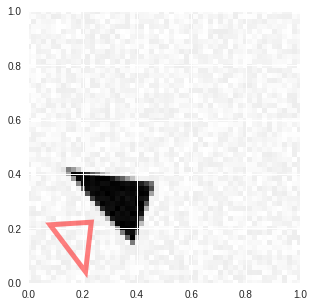

In [69]:
#Visualisation
for i in range(1) :
    sample = random.randint(0,X_test.shape[0]-1)
    
    print("Visualization of X_test[", sample,"], Y[",sample,"]")
    visualize_prediction(X_test[sample], Y[sample])
    
#    print("Visualization of X_test[", sample,"], Y_test[",sample,"]")
#    visualize_prediction(X_test[sample], Y_test_norm[sample])
    
#    u = min(Y_test[sample,0],Y_test[sample,2], Y_test[sample,4])
#    v = min(Y_test[sample,1],Y_test[sample,3], Y_test[sample,5])
#    Y[sample,0] = Y[sample,0] + u
#    Y[sample,1] = Y[sample,1] + v
#    Y[sample,2] = Y[sample,2] + u
#    Y[sample,3] = Y[sample,3] + v
#    Y[sample,4] = Y[sample,4] + u
#    Y[sample,5] = Y[sample,5] + v    
#    print("Visualization of X_test[", sample,"], Y[",sample,"]")
#    visualize_prediction(X_test[sample], Y[sample])

In [0]:
#Try to learn the translation
Y_train_norm = np.zeros((Y_train.shape[0],Y_train.shape[1]+2))
Y_test_norm = np.zeros((Y_test.shape[0],Y_test.shape[1]+2))
for n in range(Y_train.shape[0]) :
    u = min(Y_train[n,0],Y_train[n,2], Y_train[n,4])
    v = min(Y_train[n,1],Y_train[n,3], Y_train[n,5])
    Y_train_norm[n,0] = Y_train[n,0] - u
    Y_train_norm[n,1] = Y_train[n,1] - v
    Y_train_norm[n,2] = Y_train[n,2] - u
    Y_train_norm[n,3] = Y_train[n,3] - v
    Y_train_norm[n,4] = Y_train[n,4] - u
    Y_train_norm[n,5] = Y_train[n,5] - v
    Y_train_norm[n,6] = u
    Y_train_norm[n,7] = v  
for n in range(Y_test.shape[0]) :
    u = min(Y_test[n,0],Y_test[n,2], Y_test[n,4])
    v = min(Y_test[n,1],Y_test[n,3], Y_test[n,5])
    Y_test_norm[n,0] = Y_test[n,0] - u
    Y_test_norm[n,1] = Y_test[n,1] - v
    Y_test_norm[n,2] = Y_test[n,2] - u
    Y_test_norm[n,3] = Y_test[n,3] - v
    Y_test_norm[n,4] = Y_test[n,4] - u
    Y_test_norm[n,5] = Y_test[n,5] - v
    Y_test_norm[n,6] = u
    Y_test_norm[n,7] = v
    
model3 = Sequential()
model3.add(Conv1D(16, 5, input_shape=(X_train.shape[1],1), activation='relu'))
model3.add(Dropout(0.1))
model3.add(Conv1D(16, 5, activation='relu'))
model3.add(MaxPooling1D())
model3.add(Dropout(0.1))
model3.add(Conv1D(16, 5, activation='relu'))
model3.add(MaxPooling1D())
model3.add(Flatten())
model3.add(Dense(16, activation="softmax"))
model3.add(Dense(8, activation="softmax"))
model3.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])

model3.summary()

model3.fit(X_train.reshape((X_train.shape[0], -1, 1)), Y_train_norm, batch_size=64, nb_epoch=500)

#Prediction and evaluation
Y = model3.predict(X_test.reshape((X_test.shape[0], -1 ,1)))
model3.evaluate(X_test.reshape((X_test.shape[0], -1 ,1)), Y_test_norm)



In [0]:
#Visualisation
for i in range(1) :
    sample = random.randint(0,X_test.shape[0]-1)
    
    prediction = np.zeros((1,6))
    prediction[0, 0] = Y[sample,0] + Y[sample,6]
    prediction[0, 1] = Y[sample,1] + Y[sample,7]
    prediction[0, 2] = Y[sample,2] + Y[sample,6]
    prediction[0, 3] = Y[sample,3] + Y[sample,7]
    prediction[0, 4] = Y[sample,4] + Y[sample,6]
    prediction[0, 5] = Y[sample,5] + Y[sample,7]
    
    #print("Visualization of X_test[", sample,"], Y[",sample,"]")
    #visualize_prediction(X_test[sample], Y[sample, 0:6])
    
    print("Visualization of X_test[", sample,"], Y[",sample,"] with translation")
    visualize_prediction(X_test[sample], prediction)
    
    #print("Visualization of X_test[", sample,"], Y_test[",sample,"]")
    #visualize_prediction(X_test[sample], Y_test[sample])

**PART 6 : BONUS QUESTION**

In this part, we aim at creating a network able to denoise images. We choose a hourglass architecture : first, we use convolution and max-pooling layers, then we add convolution and up-sampling layers and finally we apply fully connected layers. We use Adam optimizer and binary crossentropy loss. The model has 98085592 parameters.

To seep up the compilation time, we reduce image size by a factor of 4. Our train set is made of 3000 samples and our test set is made of 100 samples. The fitting takes 10 epochs. At the end on the training, we reach a loss of 6.0408 and an accuracy of 0.2004.

We evaluate the model on the testing set and we get a loss of 6.0171746826171875 and an accuracy of 0.20328400135040284.

On débruite correctement la forme : le noir est plus pur. On obtient aussi un fond plus homogène mais toujours pas blanc.

In [0]:
#hourglass network for denoising
reduce_factor = 1

X_train, Y_train = generate_dataset_denoising(nb_samples=3000, noise=30.0, size_reduction=reduce_factor)
X_train = X_train.reshape((3000, -1, 1))

X_test, Y_test = generate_dataset_denoising(nb_samples=100, noise=30.0, size_reduction=reduce_factor)
X_test = X_test.reshape((100, -1, 1))

In [0]:
model4 = Sequential()
model4.add(Conv1D(16, 5, input_shape=(int(X_train.shape[1]/pow(reduce_factor,2)),1), activation="relu"))
model4.add(Conv1D(16, 5, activation="relu"))
model4.add(MaxPooling1D())
model4.add(Conv1D(2, 5, activation="relu"))
model4.add(Conv1D(2, 5, activation="relu"))
model4.add(MaxPooling1D())
model4.add(UpSampling1D())
model4.add(Conv1D(2, 5, activation="relu"))
model4.add(Conv1D(2, 5, activation="relu"))
model4.add(UpSampling1D())
model4.add(Conv1D(16, 5, activation="relu"))
model4.add(Conv1D(16, 5, activation="relu"))
model4.add(Flatten())
model4.add(Dense(int(X_train.shape[1]/pow(reduce_factor,2)), activation="softmax"))
model4.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model4.summary()

model4.fit(X_train, Y_train, batch_size=25, nb_epoch=10)

Y = model4.predict(X_test)
model4.evaluate(X_test, Y_test)

In [0]:
im_edge = int(math.sqrt(X_train.shape[1])/reduce_factor)
for i in range(5):
    sample = random.randint(0,X_test.shape[0]-1)
    print("X_test[",sample,"]")
    plt.imshow(X_test[sample].reshape((im_edge, im_edge)), cmap='gray')
    plt.show()
    print("Y[",sample,"]")
    plt.imshow(Y[sample].reshape((im_edge, im_edge)), cmap='gray')
    plt.show()
    print("Y_test[",sample,"]")
    plt.imshow(Y_test[sample].reshape((im_edge, im_edge)), cmap='gray')
    plt.show()